In [105]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
import keras as K
from IPython.display import display


In [119]:
width, height = K.preprocessing.image.load_img("images/content.jpg").size
img_w = 400
img_h = int(width * img_w / height)


In [131]:
def preprocess_image(image_path):
    # Util function to open, resize and format pictures into appropriate tensors
    img = K.preprocessing.image.load_img(
        image_path, target_size=(img_w, img_h)
    )
    img = K.preprocessing.image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = tf.keras.applications.vgg19.preprocess_input(img)
    return tf.convert_to_tensor(img)

In [121]:
def deprocess_image(input_image):
    x = np.reshape(input_image, (img_w, img_h, 3))
    # Remove zero-center by mean pixel
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    # 'BGR'->'RGB'
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [122]:
def imgDisplay(image_path):
    image = Image.open(image_path)
    display(image)

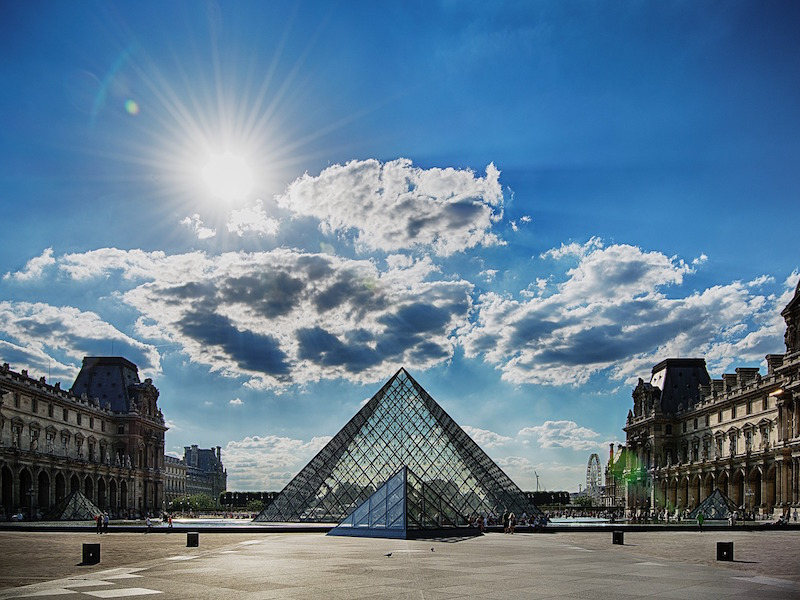

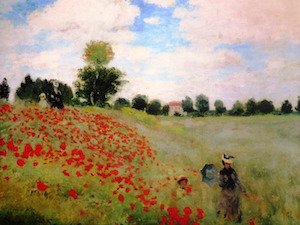

In [123]:
imgDisplay("images/content1.jpg")
imgDisplay("images/style1.jpg")


In [124]:
imputImgArray = np.random.rand(img_w,img_h, 3) * 255
inputImage = Image.fromarray(imputImgArray.astype('uint8')).convert('RGB')
inputImage.save("images/input.jpg")

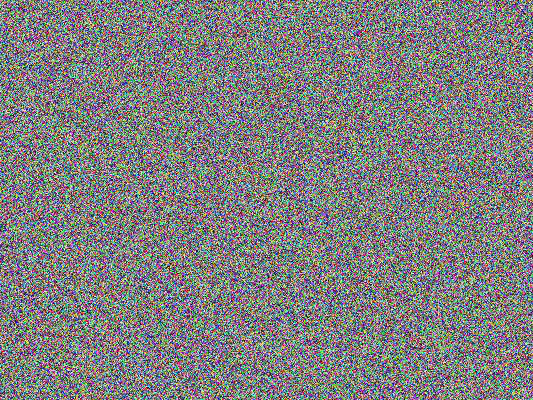

In [125]:
imgDisplay("images/input.jpg")


In [80]:
content_layers = [('block5_conv2', 0.025)]
style_layers = [('block1_conv1', .2),
                ('block2_conv1', .125),
                ('block3_conv1', 1.),
                ('block4_conv1', .3),
                ('block5_conv1', 1.)
               ]

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)


In [128]:
def get_model():
    modelVGG = tf.keras.applications.vgg19.VGG19(weights='imagenet', include_top=False)
    modelVGG.trainable = False
    model_layers = [modelVGG.get_layer(styleLayerName).output for styleLayerName, weight in style_layers]
    model_layers = model_layers + [modelVGG.get_layer(contentLayerName).output for contentLayerName, weight in content_layers]  
    model = tf.keras.Model(modelVGG.input, model_layers)
    return model

In [129]:
model = get_model()

In [134]:
styleImgTensor = preprocess_image("images/style.jpg")
contentImgTensor = preprocess_image("images/content1.jpg")
contentActivations = model(contentImgTensor)
styleActivations = model(styleImgTensor)


In [135]:
def compute_content_cost(contentActivation, targetActivation):
    m, n_w, n_h, n_c = targetActivation.get_shape().as_list()
    contentActivationUnrolled = tf.reshape(contentActivation, [m, n_w * n_h, n_c])
    targetActivationUnrolled =  tf.reshape(targetActivation, ((m, n_w * n_h, n_c)))
    content_cost = tf.math.reduce_sum(tf.square(tf.subtract(contentActivationUnrolled, targetActivationUnrolled)))
    return content_cost
    

In [136]:
def gram_matrix(activation):
    gramMatrixOfActivation = tf.matmul(activation, tf.transpose(activation))
    return gramMatrixOfActivation

In [137]:
def compute_layer_style_cost(styleActivation, targetActivation):
    m, n_w, n_h, n_c = targetActivation.get_shape().as_list()
    styleActivationUnrolled = tf.transpose(tf.reshape(styleActivation, ((n_w * n_h, n_c))), perm=[1, 0])
    targetActivationUnrolled = tf.transpose(tf.reshape(targetActivation, ((n_w * n_h, n_c))), perm=[1, 0])
    styleGramMatrix = gram_matrix(styleActivationUnrolled)
    targetGramMatrix = gram_matrix(targetActivationUnrolled)
    style_layer_cost =  tf.math.reduce_sum(tf.square(tf.subtract(styleGramMatrix, targetGramMatrix)))/(4 * (n_c * n_c) * (n_w * n_h) * (n_w * n_h))
    return style_layer_cost

In [138]:
def compute_total_content_cost(inputActivations):
    contentOnlyActivations = contentActivations[num_style_layers:]
    inputContentOnlyActivations = inputActivations[num_style_layers:]
    content_cost = 0.
    for layer_index in range(len(inputContentOnlyActivations)):
         content_cost = content_cost + content_layers[layer_index][1] * compute_content_cost(contentOnlyActivations[layer_index], inputContentOnlyActivations[layer_index])
    return content_cost

In [139]:
def compute_total_style_cost(inputActivations):
    styleOnlyActivations = styleActivations[:num_style_layers]
    inputContentOnlyActivations = inputActivations[:num_style_layers]
    style_cost = 0.
    for layer_index in range(len(inputContentOnlyActivations)):
         style_cost = style_cost + style_layers[layer_index][1] * compute_layer_style_cost(styleOnlyActivations[layer_index], inputContentOnlyActivations[layer_index])
    return style_cost

In [140]:
def compute_total_cost(cfg, alpha=10, beta=40):
    inputActivations = model(cfg['init_image'])
    totalContentCost = compute_total_content_cost(inputActivations)
    totalStyleCost = compute_total_style_cost(inputActivations)
    totalCost = alpha * totalContentCost + beta * totalStyleCost
    
    return totalCost, totalContentCost, totalStyleCost

In [141]:
def compute_grads(cfg):
    with tf.GradientTape() as tape: 
        all_loss = compute_total_cost(cfg)
    return tape.gradient(all_loss[0], cfg['init_image']), all_loss

In [143]:
def model_nn(input_image_path, num_iterations = 81):
    inputImageTensor = preprocess_image(input_image_path)
    inputImageArray = tf.Variable(inputImageTensor)
    
    iter_count = 1
   
    
    cfg = {
      'init_image': inputImageArray,
    }
    optimizer = tf.keras.optimizers.Adam(2.0)
    
    for i in range(num_iterations):
        grads, all_loss = compute_grads(cfg)
        optimizer.apply_gradients([(grads, inputImageArray)])
         # Print every 20 iteration.
        if i%10 == 0:
            print("total Loss at Iteration :" +str(i) + str(all_loss[0]))
            print("total content Loss at Iteration :" +str(i) + str(all_loss[1]))
            print("total style Loss at Iteration :" +str(i) + str(all_loss[2]))
            # Display intermediate images
            # Use the .numpy() method to get the concrete numpy array
            img = inputImageArray.numpy()
            plot_img = deprocess_image(img)
            plot_img = Image.fromarray(plot_img)
            plot_img.save("images/input"+str(iter_count)+".jpg")
            iter_count = iter_count + 1
    return inputImageArray
    

In [144]:
model_nn("images/content1.jpg")

total Loss at Iteration :0tf.Tensor(696298100000.0, shape=(), dtype=float32)
total content Loss at Iteration :0tf.Tensor(0.0, shape=(), dtype=float32)
total style Loss at Iteration :0tf.Tensor(17407453000.0, shape=(), dtype=float32)
total Loss at Iteration :10tf.Tensor(68991970000.0, shape=(), dtype=float32)
total content Loss at Iteration :10tf.Tensor(16780334.0, shape=(), dtype=float32)
total style Loss at Iteration :10tf.Tensor(1720604000.0, shape=(), dtype=float32)
total Loss at Iteration :20tf.Tensor(28715362000.0, shape=(), dtype=float32)
total content Loss at Iteration :20tf.Tensor(22207992.0, shape=(), dtype=float32)
total style Loss at Iteration :20tf.Tensor(712332100.0, shape=(), dtype=float32)
total Loss at Iteration :30tf.Tensor(14879045000.0, shape=(), dtype=float32)
total content Loss at Iteration :30tf.Tensor(25134422.0, shape=(), dtype=float32)
total style Loss at Iteration :30tf.Tensor(365692500.0, shape=(), dtype=float32)


KeyboardInterrupt: 